## Setup

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from random import choice, choices, shuffle, randint

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

     |████████████████████████████████| 993kB 3.4MB/s 


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
drop = ["Economics"]
for i in range(len(all_categories)-1, -1, -1):
    if all_categories[i] in drop:
        cat = all_categories.pop(i)
        del articles_dict[cat]
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToCNNTensor(text):
    tensor = torch.zeros(1, len(text), n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[0, idx, pos] = 1
    return tensor

print(lineToCNNTensor("Ro"))
print(lineToCNNTensor("ro").shape)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

In [4]:
training_percentage = 0.8
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]
    
def print_statistics(use_first_characters):
    print("With regards to abstracts of length at least {},".format(use_first_characters))
    for cat in all_categories:
        print("\t{:6} abstracts for {}".format(
                len(list(filter(lambda art: len(art["abstract"]) >= use_first_characters, articles_dict[cat]))),
                cat))
              
print_statistics(300)

With regards to abstracts of length at least 300,
	202723 abstracts for Physics
	140984 abstracts for Computer Science
	  6266 abstracts for Electrical Engineering and Systems Science
	136506 abstracts for Mathematics
	 25498 abstracts for Quantitative Biology
	 11504 abstracts for Quantitative Finance
	 21839 abstracts for Statistics


In [0]:
class leakyCNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(leakyCNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.leaky_relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.leaky_relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.leaky_relu(self.linear1(x)))
        return x

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
  
def topTwoFromOutput(out):
    top_n, top_i = out.topk(2)
    top_1_i = top_i[0, 0].item()
    top_2_i = top_i[0, 1].item()
    return top_1_i, top_2_i

def randomCNNTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomCNNTrainingSection(use_first_n_characters):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    abstract = ""
    while len(abstract) < use_first_n_characters:
        article = choice(training_dict[category])
        abstract = article["abstract"]
    start_slice = randint(0, len(abstract)-use_first_n_characters)
    abs_slice = abstract[start_slice : start_slice+use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abs_slice)
    return category, abs_slice, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedCNNTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(training_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomCNNTrainingExample()

def randomCNNTestingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(testing_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
randomCNNTestingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

# LEAKY model

## (1) Standard settings (52% / 75%)


With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.5% (0.0m 5.988103628158569s) 1.947 / Quantitative Biology X Mathematics
200 1.0% (0.0m 11.923245429992676s) 1.95 / Quantitative Biology X Physics
300 1.5% (0.0m 17.7958505153656s) 1.926 / Electrical Engineering and Systems Science V
400 2.0% (0.0m 23.634329080581665s) 1.95 / Quantitative Finance X Statistics
500 2.5% (0.0m 29.48695182800293s) 1.944 / Electrical Engineering and Systems Science X Computer Science
600 3.0% (0.0m 35.34072303771973s) 1.937 / Electrical Engineering and Systems Science V
700 3.5% (0.0m 41.11506795883179s) 1.946 / Mathematics X Quantitative Finance
800 4.0% (0.0m 46.91950273513794s) 1.927 / Computer Science V
900 4.5% (0.0m

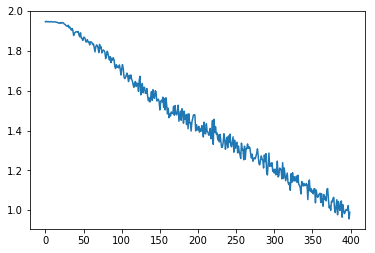

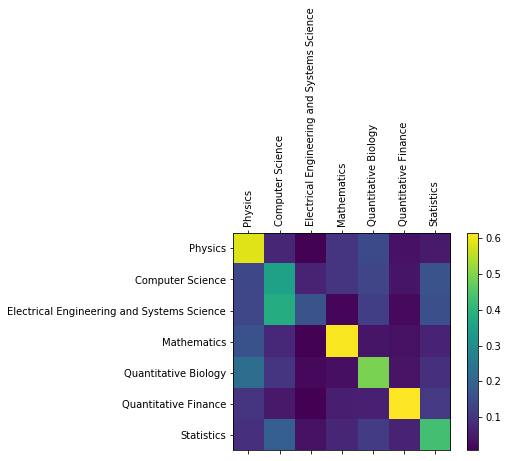

tensor([[58.,  7.,  1., 10., 14.,  3.,  5.],
        [13., 35.,  6., 10., 13.,  4., 16.],
        [13., 38., 16.,  1., 12.,  2., 15.],
        [16.,  7.,  1., 60.,  4.,  3.,  6.],
        [22., 10.,  2.,  3., 49.,  4.,  8.],
        [10.,  4.,  0.,  5.,  6., 61., 10.],
        [ 9., 18.,  3.,  7., 11.,  6., 43.]])


In [6]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 20000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (2) Double lr (55% / 77%) compared to (1)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.5% (0.0m 5.730759620666504s) 1.934 / Physics V
200 1.0% (0.0m 11.471945524215698s) 1.942 / Mathematics X Computer Science
300 1.5% (0.0m 17.221140384674072s) 1.95 / Quantitative Biology X Quantitative Finance
400 2.0% (0.0m 23.104583978652954s) 1.932 / Physics X Quantitative Finance
500 2.5% (0.0m 28.89963126182556s) 1.948 / Quantitative Biology X Mathematics
600 3.0% (0.0m 34.58896327018738s) 1.947 / Electrical Engineering and Systems Science X Quantitative Finance
700 3.5% (0.0m 40.24872612953186s) 1.954 / Quantitative Finance X Physics
800 4.0% (0.0m 45.9288375377655s) 1.94 / Mathematics X Quantitative Biology
900 4.5% (0.0m 51.601593255996704s) 

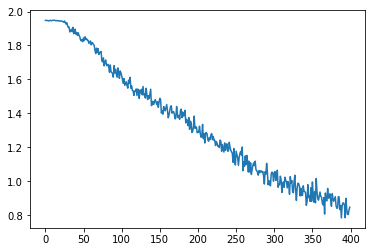

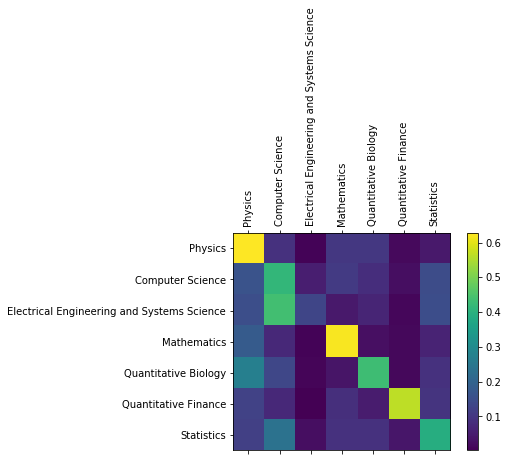

tensor([[62.,  9.,  0., 10., 10.,  1.,  4.],
        [16., 41.,  5., 10.,  8.,  2., 14.],
        [15., 43., 13.,  4.,  6.,  1., 15.],
        [18.,  7.,  0., 62.,  2.,  1.,  6.],
        [27., 13.,  1.,  3., 43.,  1.,  9.],
        [12.,  7.,  0.,  8.,  5., 56.,  9.],
        [12., 23.,  2.,  9.,  9.,  3., 39.]])


In [7]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 20000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (3) Double training (60% / 80%) compared to (2)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.25% (0.0m 5.677326440811157s) 1.946 / Electrical Engineering and Systems Science X Physics
200 0.5% (0.0m 11.373468399047852s) 1.947 / Electrical Engineering and Systems Science V
300 0.75% (0.0m 17.112164974212646s) 1.942 / Physics X Quantitative Biology
400 1.0% (0.0m 22.77678370475769s) 1.943 / Mathematics X Electrical Engineering and Systems Science
500 1.25% (0.0m 28.450714111328125s) 1.946 / Mathematics X Electrical Engineering and Systems Science
600 1.5% (0.0m 34.143906354904175s) 1.946 / Computer Science X Electrical Engineering and Systems Science
700 1.75% (0.0m 39.82669949531555s) 1.95 / Quantitative Biology X Physics
800 2.0% (0.0m 45.5

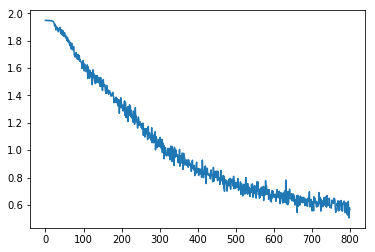

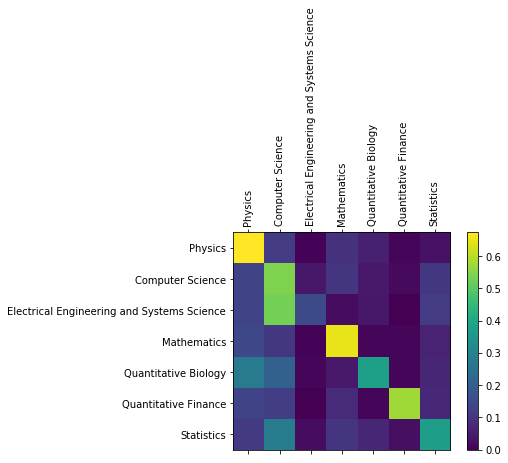

tensor([[67., 12.,  0.,  9.,  5.,  1.,  3.],
        [13., 54.,  4., 10.,  4.,  1., 11.],
        [13., 53., 15.,  2.,  4.,  0., 11.],
        [14., 10.,  0., 65.,  1.,  1.,  6.],
        [27., 20.,  0.,  4., 37.,  1.,  7.],
        [13., 12.,  0.,  8.,  1., 57.,  7.],
        [11., 28.,  2., 10.,  7.,  2., 37.]])


In [8]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 40000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (4) Double training (64% / 82%) compared to (3)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.12% (0.0m 5.6253979206085205s) 1.95 / Electrical Engineering and Systems Science X Mathematics
200 0.25% (0.0m 11.227370023727417s) 1.948 / Electrical Engineering and Systems Science X Quantitative Finance
300 0.38% (0.0m 16.846938848495483s) 1.941 / Statistics X Mathematics
400 0.5% (0.0m 22.43488121032715s) 1.941 / Quantitative Biology X Computer Science
500 0.62% (0.0m 28.10627269744873s) 1.948 / Computer Science X Mathematics
600 0.75% (0.0m 33.7682101726532s) 1.953 / Electrical Engineering and Systems Science X Quantitative Finance
700 0.88% (0.0m 39.49092435836792s) 1.93 / Physics X Computer Science
800 1.0% (0.0m 45.17457413673401s) 1.946 / Q

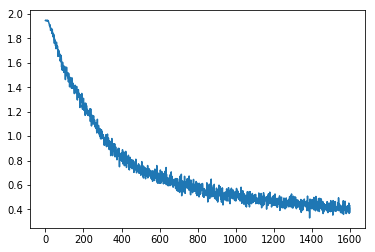

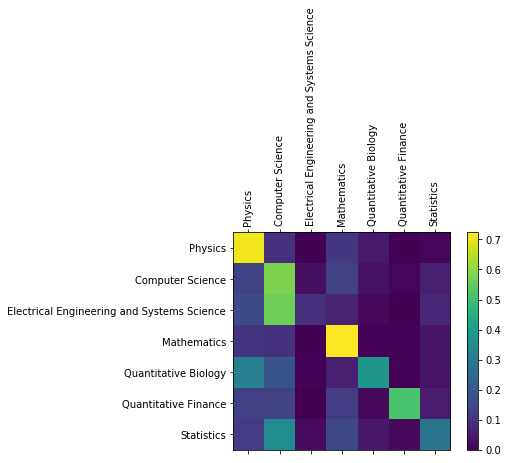

tensor([[70., 10.,  0., 11.,  5.,  0.,  1.],
        [14., 58.,  3., 13.,  3.,  0.,  6.],
        [16., 56.,  9.,  7.,  1.,  0.,  8.],
        [10., 10.,  0., 72.,  0.,  0.,  4.],
        [31., 18.,  0.,  6., 38.,  0.,  3.],
        [13., 14.,  0., 12.,  1., 51.,  5.],
        [12., 34.,  2., 15.,  4.,  1., 27.]])


In [9]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 80000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (5) Double lr, reduce training (59% / 80%) compared to (4)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.17% (0.0m 5.744919061660767s) 1.964 / Computer Science X Statistics
200 0.33% (0.0m 11.509037733078003s) 1.946 / Statistics X Computer Science
300 0.5% (0.0m 17.2708158493042s) 1.953 / Quantitative Biology X Physics
400 0.67% (0.0m 23.03552794456482s) 1.924 / Quantitative Finance V
500 0.83% (0.0m 28.808696508407593s) 1.946 / Mathematics X Electrical Engineering and Systems Science
600 1.0% (0.0m 34.56209182739258s) 1.967 / Quantitative Biology X Mathematics
700 1.17% (0.0m 40.32510232925415s) 1.961 / Computer Science V
800 1.33% (0.0m 46.09481406211853s) 1.935 / Quantitative Finance V
900 1.5% (0.0m 51.87234687805176s) 1.948 / Quantitative Finance 

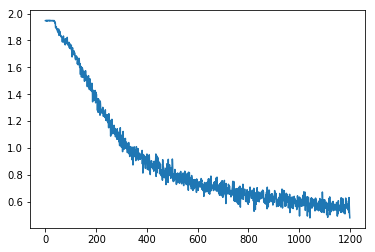

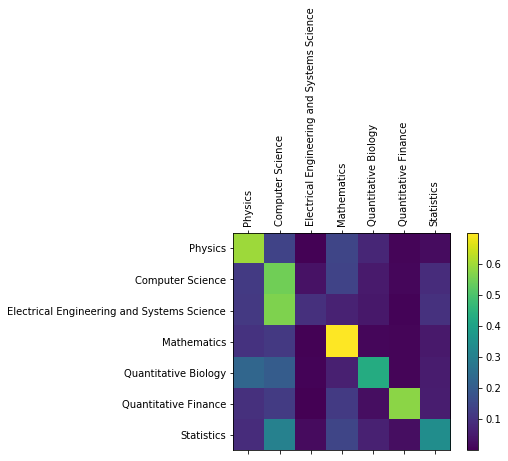

tensor([[59., 14.,  0., 14.,  7.,  0.,  2.],
        [11., 54.,  3., 14.,  5.,  1.,  9.],
        [11., 56.,  9.,  6.,  4.,  0., 10.],
        [10., 11.,  0., 69.,  1.,  1.,  4.],
        [23., 20.,  0.,  6., 42.,  1.,  5.],
        [ 9., 12.,  0., 11.,  2., 57.,  5.],
        [ 9., 30.,  2., 14.,  6.,  2., 34.]])


In [10]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.02

n_batch_iters = 60000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (6) More training, half lr (46% / 83%) compared to (4)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 5.706655979156494s) 1.954 / Physics X Mathematics
200 0.2% (0.0m 11.475017786026001s) 1.968 / Quantitative Biology X Mathematics
300 0.3% (0.0m 17.217435598373413s) 1.949 / Statistics X Quantitative Finance
400 0.4% (0.0m 23.01179552078247s) 1.952 / Electrical Engineering and Systems Science X Quantitative Biology
500 0.5% (0.0m 28.784212827682495s) 1.948 / Statistics V
600 0.6% (0.0m 34.55168890953064s) 1.937 / Quantitative Biology X Mathematics
700 0.7% (0.0m 40.2616171836853s) 1.965 / Electrical Engineering and Systems Science V
800 0.8% (0.0m 46.025521993637085s) 1.924 / Mathematics X Electrical Engineering and Systems Science
900 0.9% 

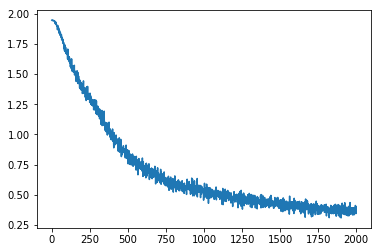

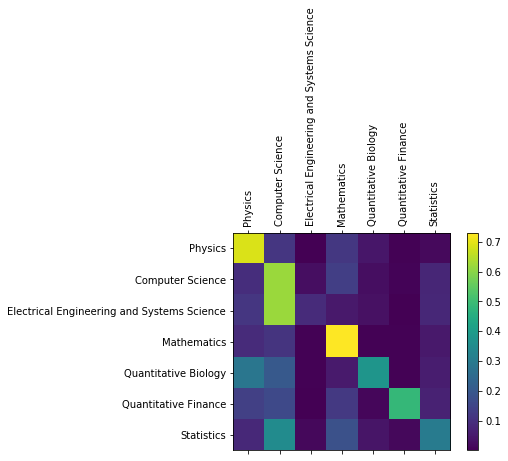

tensor([[68., 11.,  0., 11.,  4.,  0.,  2.],
        [ 9., 61.,  2., 13.,  2.,  0.,  8.],
        [11., 62.,  9.,  5.,  3.,  0.,  8.],
        [ 9., 11.,  0., 72.,  0.,  0.,  5.],
        [28., 20.,  0.,  5., 38.,  0.,  5.],
        [14., 16.,  0., 12.,  1., 48.,  7.],
        [ 8., 35.,  1., 18.,  4.,  1., 30.]])


In [11]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.005

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (7) Bigger lr (65% / 83%) compared to (6)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 5.699546575546265s) 1.949 / Electrical Engineering and Systems Science X Computer Science
200 0.2% (0.0m 11.434060096740723s) 1.948 / Physics X Statistics
300 0.3% (0.0m 17.279524087905884s) 1.952 / Physics X Mathematics
400 0.4% (0.0m 23.20224642753601s) 1.935 / Electrical Engineering and Systems Science X Quantitative Finance
500 0.5% (0.0m 28.96933627128601s) 1.949 / Electrical Engineering and Systems Science X Statistics
600 0.6% (0.0m 34.757800817489624s) 1.951 / Physics X Electrical Engineering and Systems Science
700 0.7% (0.0m 40.56351065635681s) 1.951 / Electrical Engineering and Systems Science X Statistics
800 0.8% (0.0m 46.37741

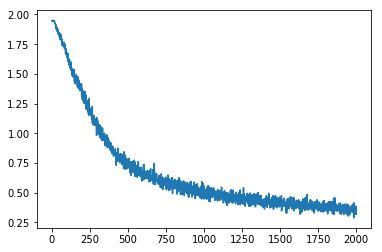

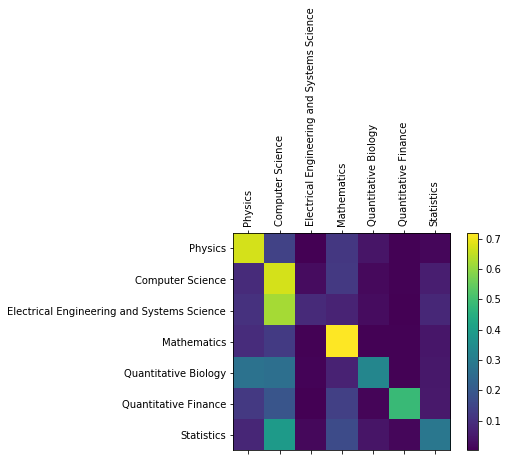

tensor([[67., 14.,  0., 11.,  4.,  0.,  1.],
        [ 8., 67.,  2., 12.,  2.,  0.,  6.],
        [10., 62.,  8.,  7.,  2.,  0.,  8.],
        [ 9., 12.,  0., 71.,  0.,  0.,  4.],
        [27., 26.,  0.,  6., 33.,  0.,  4.],
        [12., 19.,  0., 13.,  1., 48.,  5.],
        [ 7., 39.,  1., 16.,  4.,  1., 28.]])


In [12]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.008

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (8) Training from (7) and lr from (4) (64% / 82%)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.1% (0.0m 5.758511066436768s) 1.945 / Quantitative Finance X Physics
200 0.2% (0.0m 11.473401308059692s) 1.949 / Quantitative Finance X Electrical Engineering and Systems Science
300 0.3% (0.0m 17.32601308822632s) 1.941 / Computer Science X Physics
400 0.4% (0.0m 23.054880142211914s) 1.949 / Quantitative Biology X Computer Science
500 0.5% (0.0m 28.850064277648926s) 1.936 / Quantitative Biology V
600 0.6% (0.0m 34.695008516311646s) 1.957 / Electrical Engineering and Systems Science X Quantitative Finance
700 0.7% (0.0m 40.54809522628784s) 1.938 / Quantitative Finance X Electrical Engineering and Systems Science
800 0.8% (0.0m 46.31156349182129s) 1.94

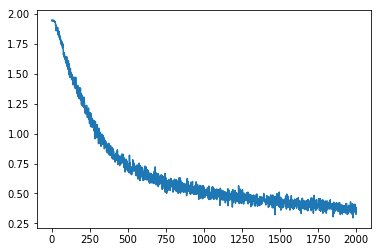

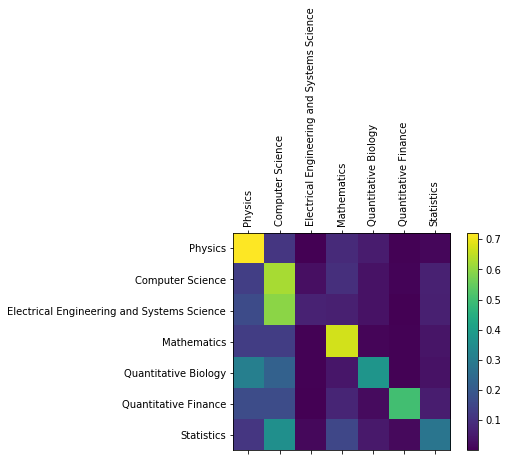

tensor([[72., 11.,  0.,  8.,  5.,  0.,  1.],
        [13., 62.,  2.,  9.,  3.,  0.,  6.],
        [16., 59.,  6.,  6.,  3.,  0.,  6.],
        [13., 13.,  0., 67.,  0.,  0.,  4.],
        [31., 22.,  0.,  4., 37.,  0.,  3.],
        [16., 16.,  0.,  7.,  2., 50.,  5.],
        [11., 35.,  1., 15.,  5.,  2., 28.]])


In [13]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.01

n_batch_iters = 100000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

## (9) train more compared to (7)

In [0]:
training_percentage = 0.9
training_dict = dict()
testing_dict = dict()
for cat in all_categories:
    all_articles = articles_dict[cat]
    shuffle(all_articles)
    p = int(len(all_articles)*training_percentage)
    training_dict[cat] = all_articles[:p]
    testing_dict[cat] = all_articles[p+1:]

learning_rate = 0.008

n_batch_iters = 150000
batch_size = 25
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

use_characters = 140
print_statistics(use_characters)

model = leakyCNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

start = time.time()

for it in range(1, n_batch_iters+1):
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

rights = 0
wrongs = 0
top2rights = 0
top2wrongs = 0
confusion = torch.zeros(n_categories, n_categories)
with torch.no_grad():
  for cat in all_categories:
      for article in testing_dict[cat]:
          if len(article["abstract"]) < use_characters:
              continue
          abstract_tensor = lineToCNNTensor(article["abstract"][:use_characters]).unsqueeze_(0).cuda()
          cat_i = all_categories.index(cat)
          category_tensor = torch.tensor([cat_i], dtype=torch.long).cuda()
          output = model(abstract_tensor)
          guess1, guess2 = topTwoFromOutput(output)
          if guess1 == cat_i:
              rights += 1
              top2rights += 1
          else:
              wrongs += 1
              if guess2 == cat_i:
                  top2rights += 1
              else:
                  top2wrongs +=1
          confusion[cat_i][guess1] += 1
print("{} accuracy out of {} tests".format(round(100*rights/(rights+wrongs),2), rights+wrongs))
print("Top 2 accuracy was {}".format(round(100*top2rights/(top2rights+top2wrongs), 2)))


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

print(confusion*1000//10)

With regards to abstracts of length at least 140,
	206044 abstracts for Physics
	143111 abstracts for Computer Science
	  6318 abstracts for Electrical Engineering and Systems Science
	153542 abstracts for Mathematics
	 25718 abstracts for Quantitative Biology
	 11787 abstracts for Quantitative Finance
	 22070 abstracts for Statistics
100 0.07% (0.0m 5.6964709758758545s) 1.954 / Physics X Statistics
200 0.13% (0.0m 11.414698123931885s) 1.935 / Statistics X Electrical Engineering and Systems Science
300 0.2% (0.0m 17.185288429260254s) 1.932 / Computer Science V
400 0.27% (0.0m 23.053529977798462s) 1.94 / Physics X Mathematics
500 0.33% (0.0m 28.895026445388794s) 1.949 / Quantitative Biology X Quantitative Finance
600 0.4% (0.0m 34.631996393203735s) 1.936 / Quantitative Biology X Statistics
700 0.47% (0.0m 40.36998462677002s) 1.954 / Quantitative Finance X Statistics
800 0.53% (0.0m 46.098541498184204s) 1.933 / Quantitative Biology X Quantitative Finance
900 0.6% (0.0m 51.83388566970825s